In [2]:
# Step 1: Clone the FlowTurbo repository
!git clone https://github.com/AasthaMariamJohn/FlowTurbo-Implementation.git

# Step 2: Moving to correct folder
%cd FlowTurbo-Implementation
%cd code

# Step 3: Setting up environment
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install tqdm numpy pillow scipy matplotlib
!pip install einops opencv-python scikit-learn
!pip install requests h5py
!wget https://cloud.tsinghua.edu.cn/f/3d07d92dd2314857ae50/?dl=1 -O SiT-XL-2-Refiner.pt
!git clone https://github.com/willisma/SiT.git

Cloning into 'FlowTurbo-Implementation'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 144 (delta 61), reused 19 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 14.22 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/FlowTurbo-Implementation
/content/FlowTurbo-Implementation/code
Looking in indexes: https://download.pytorch.org/whl/cu117
--2024-11-05 11:43:10--  https://cloud.tsinghua.edu.cn/f/3d07d92dd2314857ae50/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.15.69, 2402:f000:1:402:101:6:15:69
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.15.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/c4457c5c-d908-4544-8000-592a26dc19ab/SiT-XL-2-Refiner.pt [following]
--2024-11-05 11:43:12--  https://cloud.tsinghua.edu.cn/seaf

In [ ]:
%cd /FlowTurbo-Implementation/code/SiT

'/content'

In [2]:
# Step 4: Downloading dataset if you are intending on using ALL 1000 CLASSES
import kagglehub
tianbaiyutoby_islvrc_2012_10_pecent_subset_path = kagglehub.dataset_download('tianbaiyutoby/islvrc-2012-10-pecent-subset')
print('Data source import complete.')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data source import complete.


In [3]:
import os
dataset_path = tianbaiyutoby_islvrc_2012_10_pecent_subset_path
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_37511.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_19438.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_10769.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_29657.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_4343.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_15045.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_26680.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n03481172/n03481172_4731.JPEG
/root/.cache/ka

In [2]:
# Step 4: Downloading dataset if like me you lack computing resources,
#it is a very small dataset of only two approx classes made by me from the larger subset only consisting of two classes, dog and cat
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
dataset_path = "/content/drive/MyDrive/ILVSRC2012_Small_subset" # change path according to the path of the data folder in your drive

In [2]:
import os
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import SiT, os
os.chdir('SiT')
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
!pip install diffusers timm torchdiffeq --upgrade
# SiT imports:
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.3
    Uninstalling diffusers-0.30.3:
      Successfully uninstalled diffusers-0.30.3


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

GPU not found. Using CPU instead.


In [4]:
# Step 5: Loading and sampling pretrained SiT model
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2.70G/2.70G [02:21<00:00, 19.1MB/s]
/content/FlowTurbo-Implementation/code/SiT/download.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

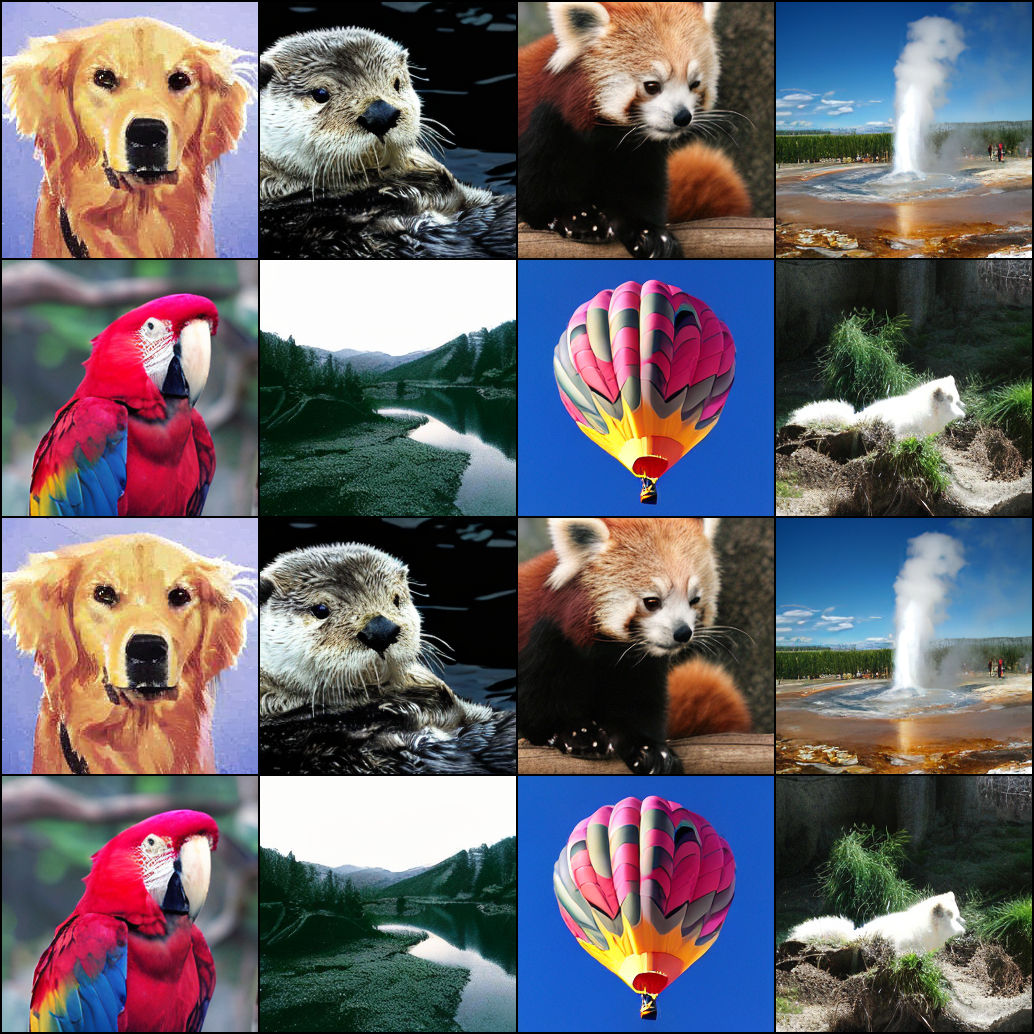

In [5]:
#VERY IMPORTANT TO RUN THIS, TAKES APPROX 2HRS
#REST OF THE CODE KEYBOARD INTERRUPTS IF THIS IS NOT
#RUN
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
sampler_type = "ODE" #@param ["ODE", "SDE"]


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler" #@param ["Euler", "Heun"]
    diffusion_form = "linear" #@param ["constant", "SBDM", "sigma", "linear", "decreasing", "increasing-decreasing"]
    diffusion_norm = 1 #@param {type:"slider", min:0, max:10.0, step:0.1}
    last_step = "Mean" #@param ["Mean", "Tweedie", "Euler"]
    last_step_size = 0.4 #@param {type:"slider", min:0, max:1.0, step:0.01}
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form,
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size,
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" #@param ["dopri5", "euler", "rk4"]
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )
samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [10]:
# Step 5: Loading and sampling the Sit - Refined Flowturbo model
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-mse" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

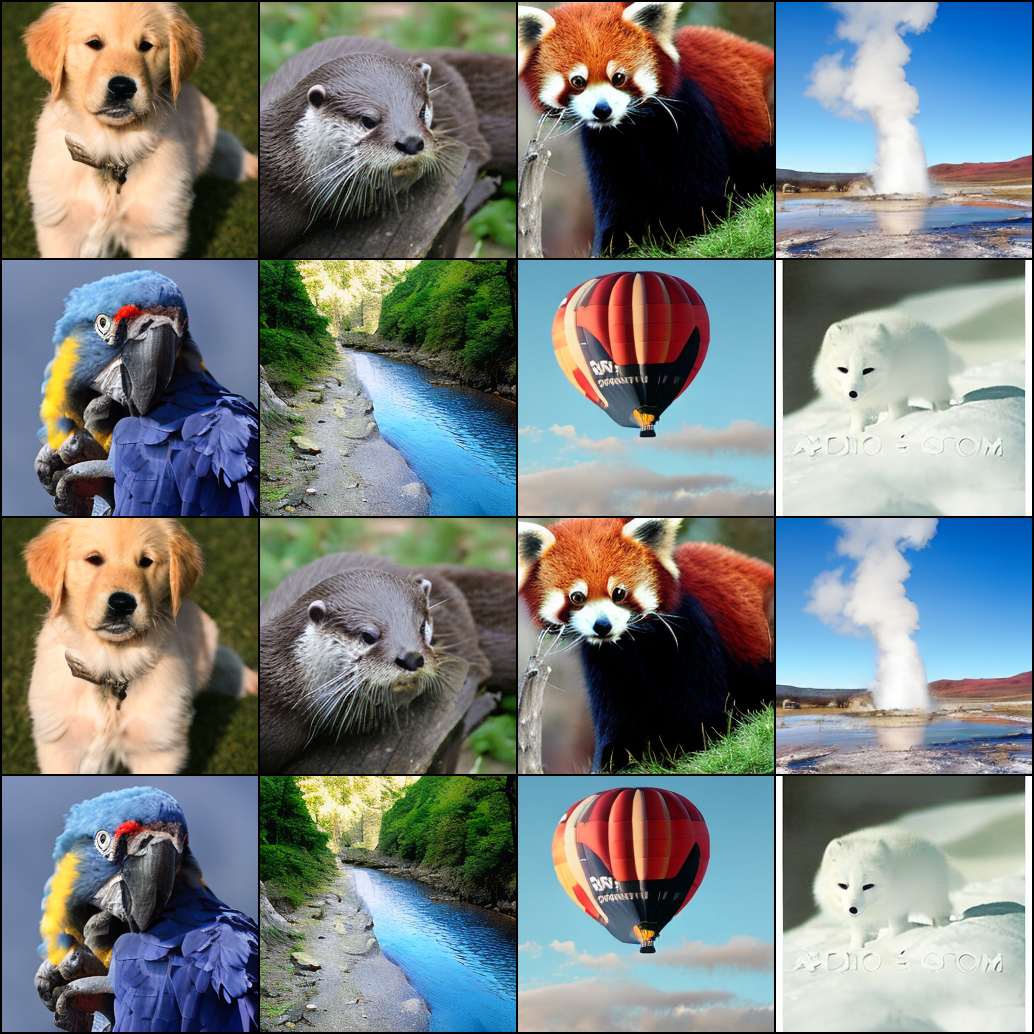

In [11]:
#VERY IMPORTANT TO RUN THIS, TAKES APPROX 2HRS
#REST OF THE CODE KEYBOARD INTERRUPTS IF THIS IS NOT
#RUN
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
sampler_type = "ODE" #@param ["ODE", "SDE"]


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler" #@param ["Euler", "Heun"]
    diffusion_form = "linear" #@param ["constant", "SBDM", "sigma", "linear", "decreasing", "increasing-decreasing"]
    diffusion_norm = 1 #@param {type:"slider", min:0, max:10.0, step:0.1}
    last_step = "Mean" #@param ["Mean", "Tweedie", "Euler"]
    last_step_size = 0.4 #@param {type:"slider", min:0, max:1.0, step:0.01}
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form,
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size,
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" #@param ["dopri5", "euler", "rk4"]
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )
samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [12]:
!pwd
%cd ..

/content/FlowTurbo-Implementation/code/SiT
/content/FlowTurbo-Implementation/code


In [ ]:
%cd FlowTurbo-Implementation/code

/content/FlowTurbo-Implementation/code


In [13]:
!mv /content/FlowTurbo-Implementation/code/SiT/pretrained_models/SiT-XL-2-256x256.pt /content/FlowTurbo-Implementation/code/

In [ ]:
%cd FlowTurbo-Implementation
%cd code

[Errno 2] No such file or directory: 'FlowTurbo-Implementation'
/content/FlowTurbo-Implementation/code
[Errno 2] No such file or directory: 'code'
/content/FlowTurbo-Implementation/code


In [14]:
# Step 6: Environment deployment
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')
!conda env create -f environment.yml
!source activate FlowTurbo

--2024-11-02 17:16:42--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local
/usr/local/lib/python3.12/argparse.py:2006: FutureWarning: `remote_d

In [15]:
# Step 7: Training
#MIN 1 GPU REQUIRED FOR TRAINING OTHERWISE IT WONT RUN, IF NO GPU THEN SKIP TO SAMPLING
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [16]:
# Set memory allocation environment variable to manage memory in segments
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU cache to avoid memory fragmentation
def clear_gpu_cache():
    torch.cuda.empty_cache()
    print("GPU cache cleared.")

clear_gpu_cache()

# Define the minimal training command with torchrun and memory optimization parameters
def run_training():
    try:
        # Clear any residual cache before starting
        clear_gpu_cache()

        # Command to start training with reduced batch size (optional)
        training_command = """
        torchrun --nnodes=1 --nproc_per_node=1 train.py \
            --model SiT-XL/2 \
            --data-path /content/drive/MyDrive/ILVSRC2012_Small_subset/train \
            --batch-size 8  # Reduce batch size if necessary to avoid OOM errors
        """

        # Run the command
        os.system(training_command)

    except torch.cuda.OutOfMemoryError:
        print("CUDA Out of Memory encountered. Consider reducing batch size further.")
        clear_gpu_cache()

    finally:
        # Clear GPU cache after training completes
        clear_gpu_cache()

# Run the training process with memory and precision optimizations
run_training()

GPU cache cleared.
GPU cache cleared.
GPU cache cleared.


In [13]:
# Minimal training with small dataset and min possible evaluation parameters
!torchrun --nnodes=1 --nproc_per_node=1 train.py --adaptive-sampling --model SiT-XL/2 --data-path /content/drive/MyDrive/ILVSRC2012_Small_subset/train

2024-11-04 02:20:06.745353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 02:20:06.769145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 02:20:06.776413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 02:20:08.471248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
CUDA is not available. Switching to simulation mode...
2024-11-04 02:09:42.760621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has 

In [ ]:
# Training with the full 1000 class dataset, not possible with the google collab GPU will need better acess
!CUDA_VISIBLE_DEVICES=0 torchrun --nnodes=1 --nproc_per_node=1 --master_port 12345 train.py \
    --adaptive-sampling \
    --data-path /root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/ \
    --global-batch-size 18 \
    --note 'TRIAL 1' \
    --ckpt-every 5000 \
    --lr 5e-5 \
    --vae_ckpt stabilityai/sd-vae-ft-ema \
    --model_teacher_ckpt SiT-XL-2-256x256.pt

/usr/bin/python3: can't open file '/content/train.py': [Errno 2] No such file or directory
E1022 16:59:27.341000 133437221425152 torch/distributed/elastic/multiprocessing/api.py:833] failed (exitcode: 2) local_rank: 0 (pid: 530) of binary: /usr/bin/python3
Traceback (most recent call last):
  File "/usr/local/bin/torchrun", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 348, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/run.py", line 901, in main
    run(args)
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/run.py", line 892, in run
    elastic_launch(
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/launcher/api.py", line 133, in __call__
    return launch_agent(self._config, self._entrypoint, list(args))
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/launcher/api

In [18]:
!pip install IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.9/819.9 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.3 MB/s eta 0:00:00


In [2]:
%cd FlowTurbo-Implementation/code

/content/FlowTurbo-Implementation/code


In [3]:
# Step 8: Testing the results
!python sample.py --adaptive-sampling --predictor_ckpt SiT-XL-2-256x256.pt --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_samples 100 --output_dir ./samples --image_resolution 256x256

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/content/FlowTurbo-Implementation/code/models_assemble.py:563: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

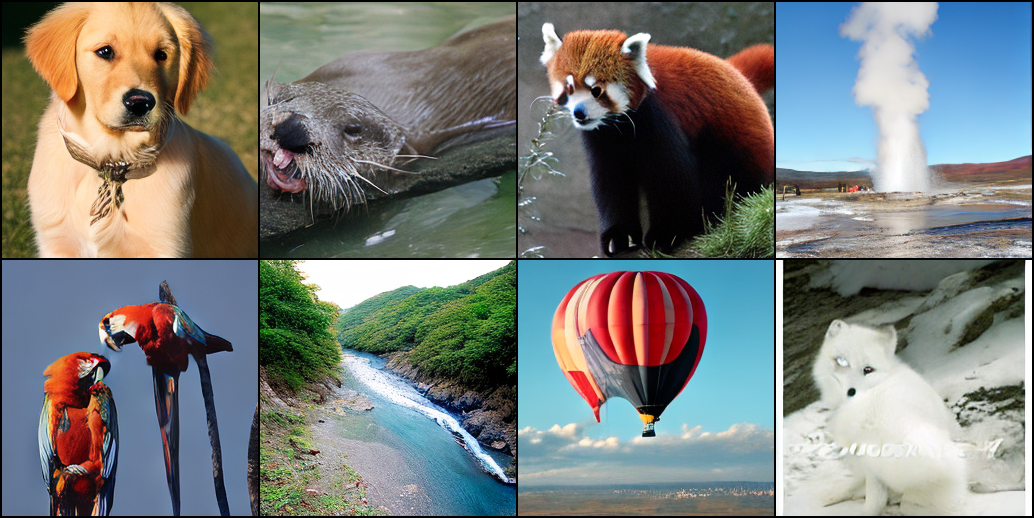

In [4]:
from IPython.display import Image, display
image_path = "sample_N_H1N_P5N_R3SACFalse.png"
display(Image(image_path))

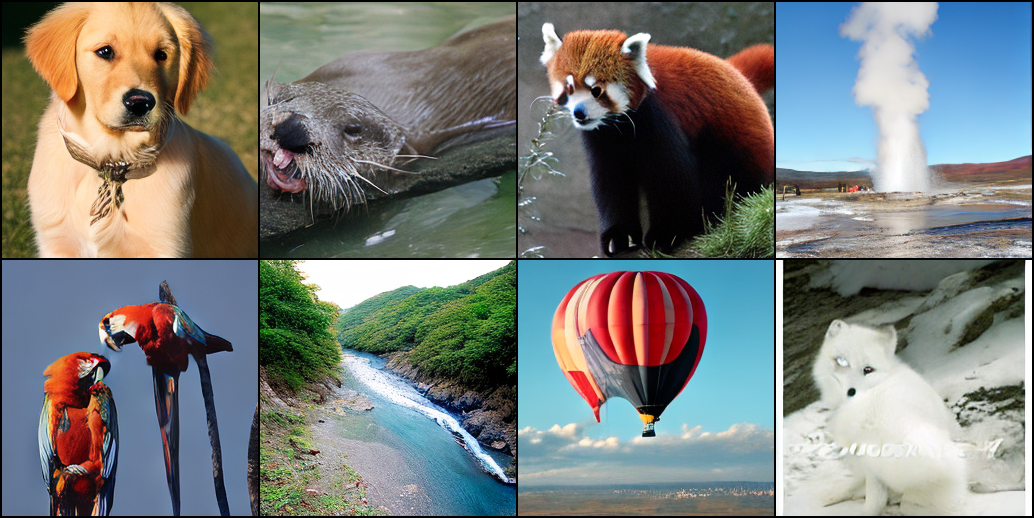

In [ ]:
from IPython.display import Image, display
image_path = "sample_N_H1N_P5N_R3SACFalse.png"
display(Image(image_path))

In [ ]:
!pwd
%cd FlowTurbo-Implementation/code

/content/FlowTurbo-Implementation/code


In [ ]:
mkdir -p ./samples

In [ ]:
ls

download.py*         requirements.txt*                sample.py*           train_utils.py*
environment.yml*     sample_ddp_feature.py*           samples/             transport/
evaluation/          sample_in_dir.py                 SiT/
LICENSE*             sample_N_H1N_P5N_R3SACFalse.png  SiT-XL-2-Refiner.pt
models_assemble.py*  sample.png                       train.py*


In [5]:
# Step 9: Sampling to get output for the evaluation scripts to run
#NEEDS ATLEAST 1 GPU WILL NOT RUN ON CPU
!python sample_ddp_feature.py \
    --adaptive-sampling \
    --vae_ckpt stabilityai/sd-vae-ft-ema \
    --predictor_ckpt SiT-XL-2-256x256.pt \
    --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_fid_samples 60 --per_proc_batch_size 10 --cfg_scale 1.5 \
    --tag TEST

Traceback (most recent call last):
  File "/content/FlowTurbo-Implementation/code/sample_ddp_feature.py", line 221, in <module>
    main(args)
  File "/usr/local/lib/python3.12/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/FlowTurbo-Implementation/code/sample_ddp_feature.py", line 58, in main
    dist.init_process_group("nccl")
  File "/usr/local/lib/python3.12/site-packages/torch/distributed/c10d_logger.py", line 83, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/torch/distributed/c10d_logger.py", line 97, in wrapper
    func_return = func(*args, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/torch/distributed/distributed_c10d.py", line 1520, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
                              ^

In [6]:
# Made a new script that works on CPU but gives only 8 samples
!python sample_in_dir.py \
    --adaptive-sampling \
    --predictor_ckpt SiT-XL-2-256x256.pt \
    --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_samples 100 \
    --output_dir ./samples \
    --image_resolution 256x256

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/content/FlowTurbo-Implementation/code/models_assemble.py:563: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

In [8]:
# Step 10: Evaluation (Full)
#Please download the reference file to do the evaluation
# the reference npz can be downloaded via
# https://openaipublic.blob.core.windows.net/diffusion/jul-2021/ref_batches/imagenet/256/VIRTUAL_imagenet256_labeled.npz
# File is 2GB
!python evaluation/evaluator.py ./VIRTUAL_imagenet256_labeled.npz ./sample.zip

Traceback (most recent call last):
  File "/content/FlowTurbo-Implementation/code/evaluation/evaluator.py", line 16, in <module>
    import tensorflow.compat.v1 as tf
ModuleNotFoundError: No module named 'tensorflow'


In [ ]:
import torchvision.models as models

# Load the pre-trained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.7MB/s] 


In [3]:
# Step 10: Evaluation new created by me to compare image to image
!python fid.py
!python precision_recall.py

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100% 104M/104M [00:00<00:00, 178MB/s] 
FID score: 3.0996851603190105
Precision: 0.625
Recall: 0.8333333333333334
